# Housekeeping

In [1]:
if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## Library Imports

In [2]:
# Core Libraries
import pandas as pd
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import set_config
import re
import json

#Group splitting
from sklearn.model_selection import GroupShuffleSplit

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

# Custom Functions
from functions import set_global_seeds, MASTER_SEED
from functions import clr_transform
from functions import filter_features_by_level, feature_selection_pipeline
from functions import random_forest_benchmark
from functions import xgboost_benchmark
from functions import plot_residuals_analysis, plot_model_comparison_heatmap

## Settings

In [3]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
print(Style.RESET_ALL)
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)


Global seeds set to 3004


## Encoded Data Import

In [4]:
encoded_samples = pd.read_csv("processed_data/encoded_samples.csv")

assert encoded_samples.shape == (808, 6907), "Data has the wrong shape. Check the CSV formatting."

# Data Preparation

## Train-test split 

In [31]:
feature_cols = encoded_samples.columns.difference(["sample_id", "age_group_at_sample"]) # These variables will get removed from X

X = encoded_samples[feature_cols]
Y = encoded_samples["age_group_at_sample"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=MASTER_SEED)
train_indicies, test_indicies = next(gss.split(X, Y, groups=X['family_id']))
X_train_raw = X.iloc[train_indicies]
X_test_raw = X.iloc[test_indicies]
Y_train = Y.iloc[train_indicies]
Y_test = Y.iloc[test_indicies]

assert X_train_raw.shape[1] == X_test_raw.shape[1], "Feature columns do not match between train and test sets."
assert X_train_raw.shape[0] == Y_train.shape[0] and X_test_raw.shape[0] == Y_test.shape[0], "X and Y do not have the same length."

print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)

Train shape: (628, 6905) | Test shape: (180, 6905)


In [32]:
#Storing the test sets for use in other notebooks

%store Y_train
%store Y_test

Stored 'Y_train' (Series)
Stored 'Y_test' (Series)


## Filtering for features

### Genus Level

In [33]:
X_train_genus_raw = filter_features_by_level(X_train_raw, max_level="Genus")
X_train_genus_filtered, _ = feature_selection_pipeline(X_train_genus_raw, Y_train)
X_train_genus = clr_transform(X_train_genus_filtered)

X_test_genus = clr_transform(X_test_raw[X_train_genus.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 154 | Removed: 2167
Best Filtering Parameters Found: {'prevalence_thresh': 0.04844190317660929, 'abundance_thresh': 7.1803873767309e-05, 'variance_thresh': 8.401933758108652e-06, 'corr_thresh': 0.9937458277619593}


In [34]:
#Storing X_train and X_test for other notebooks
%store X_train_genus
%store X_test_genus

Stored 'X_train_genus' (DataFrame)
Stored 'X_test_genus' (DataFrame)


### Species Level

In [9]:
X_train_species_raw = filter_features_by_level(X_train_raw, max_level="Species")
X_train_species_filtered, _ = feature_selection_pipeline(X_train_species_raw, Y_train)
X_train_species = clr_transform(X_train_species_filtered)

X_test_species = clr_transform(X_test_raw[X_train_species.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 325 | Removed: 4207
Best Filtering Parameters Found: {'prevalence_thresh': 0.0445294932513603, 'abundance_thresh': 0.0001314772523015243, 'variance_thresh': 3.516793174173602e-06, 'corr_thresh': 0.9717650334933523}


## Shape of Data per Level

In [10]:
print(f"Genus Level: {X_train_genus.shape[1]} features | Species Level: {X_train_species.shape[1]}")

Genus Level: 137 features | Species Level: 325


# Models Training

## Initialise model results tracking

In [11]:
model_results = []
print("Model results tracking initialized")

Model results tracking initialized


## Random Forest Regressor on Genus Level

### Base Model

In [12]:
rf_base = RandomForestRegressor(
    random_state=MASTER_SEED,
    n_jobs=-1,
    oob_score=True
)

rf_base.fit(X_train_genus, Y_train)
yhat_rf_genus = rf_base.predict(X_test_genus)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_rf_genus):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_rf_genus)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_rf_genus):.3f}")


Mean Squared Error: 4540.724
Best CV RMSE: 67.385
R2 Score: 0.757


### Search for the best model

In [13]:
rf_results = random_forest_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {rf_results.best_params}")

Initializing Random Forest Engine: Genus Level
Fitting 7 folds for each of 13 candidates, totalling 91 fits


/home/kuba/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/kuba/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/kuba/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/kuba/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `


Genus Level RF Complete (27.8s) | R2: 0.757

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None}


In [14]:
# Track Random Forest results
model_results.append({
    'model': 'Random Forest',
    'rmse': rf_results.rmse,
    'r2': rf_results.r2,
    'best_params': rf_results.best_params,
    'label' : 'Genus Level'
})

In [15]:
print(f"Mean Squared Error: {rf_results.rmse**2:.3f}") # Squared because rmse is sqrt(mse)
print(f"Best CV RMSE: {rf_results.rmse:.3f}")
print(f"R2 Score: {rf_results.r2:.3f}")

best_rf_model = rf_results.model
yhat = rf_results.model.predict(X_test_genus)

Mean Squared Error: 4534.336
Best CV RMSE: 67.337
R2 Score: 0.757


## XGBoost Regressor on Genus Level

In [16]:
# Base model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=MASTER_SEED,
    n_jobs=-1
)

X_train_clean = X_train_genus.copy()
X_train_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_train_clean.columns]
X_test_clean = X_test_genus.copy()
X_test_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_test_clean.columns]


xgb_base.fit(X_train_clean, Y_train)
yhat_xgb_genus = xgb_base.predict(X_test_clean)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_xgb_genus):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_xgb_genus)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_xgb_genus):.3f}")

Mean Squared Error: 5362.218
Best CV RMSE: 73.227
R2 Score: 0.713


### Best XGBoost Parameters Search

In [17]:
xgboost_results = xgboost_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)
print(f"Best hyperparameters: {xgboost_results.best_params}")

Initializing XGBoost Engine: Genus Level
Fitting 7 folds for each of 13 candidates, totalling 91 fits

Genus Level Complete (52.5s) | R2: 0.760
Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.2}


In [18]:
# Track XGBoost results
model_results.append({
    'model': 'XGBoost',
    'rmse': xgboost_results.rmse,
    'r2': xgboost_results.r2,
    'best_params': xgboost_results.best_params,
    'label' : 'Genus Level'
})


## Random Forest Regressor on Species Level

### Base model

In [19]:
rf_base = RandomForestRegressor(
    random_state=MASTER_SEED,
    n_jobs=-1,
    oob_score=True
)

rf_base.fit(X_train_species, Y_train)
yhat_rf_species = rf_base.predict(X_test_species)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_rf_species):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_rf_species)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_rf_species):.3f}")


Mean Squared Error: 3849.511
Best CV RMSE: 62.044
R2 Score: 0.794


### Search for the best model

In [20]:
rf_results = random_forest_benchmark(
    X_train_species,
    X_test_species,
    Y_train,
    Y_test,
    label="Species Level"
)

print(f"\nBest hyperparameters: {rf_results.best_params}")

Initializing Random Forest Engine: Species Level
Fitting 7 folds for each of 13 candidates, totalling 91 fits

Species Level RF Complete (41.7s) | R2: 0.792

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None}


In [21]:
# Track Random Forest results
model_results.append({
    'model': 'Random Forest',
    'rmse': rf_results.rmse,
    'r2': rf_results.r2,
    'best_params': rf_results.best_params,
    'label' : 'Species Level'
})

## XGBoost Regressor on Species Level

In [22]:
# Base model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=MASTER_SEED,
    n_jobs=-1
)

X_train_clean = X_train_species.copy()
X_train_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_train_clean.columns]
X_test_clean = X_test_species.copy()
X_test_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_test_clean.columns]


xgb_base.fit(X_train_clean, Y_train)
yhat_xgb = xgb_base.predict(X_test_clean)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_xgb):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_xgb)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_xgb):.3f}")

Mean Squared Error: 4121.326
Best CV RMSE: 64.198
R2 Score: 0.779


### Best XGBoost Parameters Search

In [23]:
xgboost_results = xgboost_benchmark(
    X_train_species,
    X_test_species,
    Y_train,
    Y_test,
    label="Species Level"
)
print(f"Best hyperparameters: {xgboost_results.best_params}")

Initializing XGBoost Engine: Species Level
Fitting 7 folds for each of 13 candidates, totalling 91 fits

Species Level Complete (114.2s) | R2: 0.817
Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 5.0, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.2}


In [24]:
# Track XGBoost results
model_results.append({
    'model': 'XGBoost',
    'rmse': xgboost_results.rmse,
    'r2': xgboost_results.r2,
    'best_params': xgboost_results.best_params,
    'label' : 'Species Level'
})
print(model_results)

[{'model': 'Random Forest', 'rmse': np.float64(67.33748143005351), 'r2': 0.7571072079806128, 'best_params': {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None}, 'label': 'Genus Level'}, {'model': 'XGBoost', 'rmse': np.float64(66.94955686233106), 'r2': 0.7598977088928223, 'best_params': {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.2}, 'label': 'Genus Level'}, {'model': 'Random Forest', 'rmse': np.float64(62.304479400415325), 'r2': 0.7920593330805485, 'best_params': {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': None}, 'label': 'Species Level'}, {'model': 'XGBoost', 'rmse': np.float64(58.473975498052766), 'r2': 0.8168419003486633, 'best_params': {'subsample': 0.7, 'reg_lambda': 5.0, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.2},

In [37]:
#Storing model_results for other notebooks

with open('processed_data/model_results.json', 'w') as f:
    json.dump(model_results, f)

#  Comparison of models

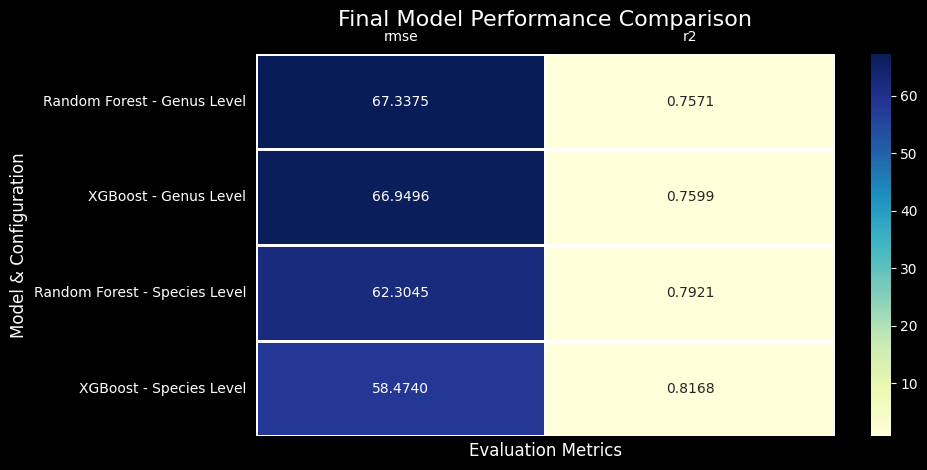

In [26]:
#TODO: Duplicate this notebook and make the new copy simply on visualisations
plot_model_comparison_heatmap(model_results, title="Final Model Performance Comparison")

## Base Visualisations

### Training the best model

In [27]:
rf_params = model_results[0]['best_params']
best_rf = RandomForestRegressor(
    **rf_params,
    random_state=MASTER_SEED,
    n_jobs=-1
)

best_rf.fit(X_train_genus, Y_train)
yhat_best = best_rf.predict(X_test_genus)

NameError: name 'X_train_genus' is not defined

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_best, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

In [ ]:
residuals = Y_test - yhat_best

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat_best, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

In [ ]:
importances = pd.Series(
    best_rf_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [ ]:
st = SuperTree(
    best_rf_model,
    X_train_genus,
    Y_train
)

st.show_tree(which_tree=0)

In [ ]:
# get predictions from each tree on the test set
all_tree_preds = np.array([tree.predict(X_test_genus) for tree in best_rf_model.estimators_])

# compute the mean prediction (Random Forest final prediction)
rf_pred = all_tree_preds.mean(axis=0)

# compute standard deviation per sample (uncertainty)
rf_std = all_tree_preds.std(axis=0)

plt.figure(figsize=(10,6))

# plot all tree predictions (semi-transparent lines)
for i in range(all_tree_preds.shape[0]):
    plt.plot(Y_test.values, all_tree_preds[i], 'o', color='lightgray', alpha=0.3)

# plot Random Forest mean prediction
plt.scatter(Y_test, rf_pred, color='blue', label='RF mean prediction', s=40)

plt.errorbar(Y_test, rf_pred, yerr=rf_std, fmt='o', color='red', alpha=0.5, label='±1 std across trees')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("Random Forest – Forest plot of tree predictions")
plt.legend()
plt.tight_layout()
plt.show()


## Advanced Visualisations

In [ ]:
plot_residuals_analysis(Y_test, yhat_best, title="Random Forest Residuals Analysis")

In [ ]:
# Prediction intervals (showing uncertainty from individual trees)
plot_prediction_intervals(
    Y_test,
    yhat_best,
    prediction_std=rf_std,
    sample_indices=range(50),  # Show first 50 samples
    title="Random Forest Predictions with Uncertainty"
)

In [ ]:
# Learning curves to check for overfitting

plot_learning_curves(
    best_rf,
    X_train_genus,
    Y_train,
    cv_folds=7,
    title="Random Forest Learning Curves (Genus Level)"
)